# 1. Modelling

Logistic Regression and Gradient Boosting (2 models)

## 1.1 Importing and Processing Data

In [1]:
import pandas as pd

file_path = "./data/stage_2/ObesityDataSet_raw_and_data_sinthetic.csv"

# Read CSV using pandas
df_01 = pd.read_csv(file_path, encoding="utf-8")
df_02 = df_01.dropna()


In [2]:
# Features
categorical_features = [
    "Gender",
    "family_history_with_overweight",
    "FAVC",
    "CAEC",
    "SMOKE",
    "SCC",
    "CALC",
    "MTRANS"
]
numeric_features = [
    "Age",
    "Height",
    "Weight",
    "FCVC",
    "NCP",
    "CH2O",
    "FAF",
    "TUE"
]
target = 'NObeyesdad'


In [31]:
# assign order to the target variable 
obe_order = [
    'Insufficient_Weight',
    'Normal_Weight',
    'Overweight_Level_I',
    'Overweight_Level_II',
    'Obesity_Type_I',
    'Obesity_Type_II',
    'Obesity_Type_III'
]


## 1.2 Training Datasets and Testing Datasets

In [37]:
from sklearn.model_selection import train_test_split


X = df_02.loc[:, numeric_features + categorical_features]
Y = df_02[target]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                        test_size=0.3, random_state=43, stratify=Y)

print(X.index.equals(Y.index))
print(X_train.index.equals(Y_train.index))
print(X_test.index.equals(Y_test.index))


True
True
True


## 1.3 Evaluation Function

In [38]:
from sklearn.metrics import classification_report


def print_classification_report(model, x_t, y_t):
    print(f'1 --> print_classification_report {obe_order}')
    key=', '.join(['{}={}'.format(i,name) for i, name in enumerate(obe_order)])
    print(classification_report(y_t, model.predict(x_t), labels=obe_order, target_names=obe_order))

In [60]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


def plt_confusion_matrix(model, x_t, y_t):
    print(f'2 --> plt_confusion_matrix {obe_order}')

    key=', '.join(['{}={}'.format(i,name) for i, name in enumerate(obe_order)])
    print('Confusion matrix ({}):\n'.format(key))

    plt.matshow(confusion_matrix(y_t, model.predict(x_t), labels=obe_order), interpolation='nearest')
    plt.colorbar()
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    plt.show()

In [7]:
import math
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc


def plt_multi_roc(model, x_t, y_t):
    print(f'3 --> plt_multi_roc {obe_order}')

    plt.rcParams.update({'font.size': 10})

    # Binarized labels
    y_test_bin = label_binarize(y_t, classes=obe_order)

    # y_pred_probe
    order_indices = [list(model.classes_).index(c) for c in obe_order]
    y_pred_probe = model.predict_proba(x_t)[:, order_indices]

    # plt ROC
    size = len(obe_order)
    c = 4
    r = math.ceil(size / c)

    plt.figure(figsize=(12, r * 12 / c))
    ax = plt.gca()
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.set_title('Multi-class ROC Curve (label_binarize)')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    for i in range(size):
        plt.subplot(r, c, i + 1)

        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probe[:, i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, color='green', lw=2)
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.grid(True, alpha=0.3)

        ax = plt.gca()
        ax.set(ylabel=None)
        ax.set(xlabel=f'{obe_order[i]} (AUC = {roc_auc:.2f})')



In [8]:
import math
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score


def plt_multi_pr(model, x_t, y_t):
    print(f'4 --> plt_multi_pr {obe_order}')

    plt.rcParams.update({'font.size': 10})

    # Binarized labels
    y_test_bin = label_binarize(y_t, classes=obe_order)

    # y_pred_probe
    order_indices = [list(model.classes_).index(c) for c in obe_order]
    y_pred_probe = model.predict_proba(x_t)[:, order_indices]

    # plt PR
    size = len(obe_order)
    c = 4
    r = math.ceil(size / c)

    plt.figure(figsize=(12, r * 12 / c))
    ax = plt.gca()
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.set_title('Multi-class PR Curve (label_binarize)')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    for i in range(size):
        plt.subplot(r, c, i + 1)

        prec, rec, _ = precision_recall_curve(y_test_bin[:, i], y_pred_probe[:, i])
        ap = average_precision_score(y_test_bin[:, i], y_pred_probe[:, i])

        plt.plot(rec, prec, color='green')
        plt.grid(True, alpha=0.3)

        ax = plt.gca()
        ax.set(ylabel=None)
        ax.set(xlabel=f'{obe_order[i]} (AP={ap:.3f})')


In [9]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

rng = np.random.default_rng(49)

def bootstrap_ci(y_true, y_pred, metric_fn, B=1000, alpha=0.05):
    print(f'5 --> bootstrap_ci B={B}, alpha={alpha}')
    n = len(y_true)
    stats = []
    for _ in range(B):
        idx = rng.integers(0, n, n)
        stats.append(metric_fn(y_true[idx], y_pred[idx]))
    lower = np.quantile(stats, alpha/2)
    upper = np.quantile(stats, 1 - alpha/2)
    return float(np.mean(stats)), float(lower), float(upper)

def my_bootstrap_ci(name, y_true, y_pred, B=1000, alpha=0.05):
    print(f'6 --> my_bootstrap_ci {name}')
    acc_mean, acc_l, acc_u = bootstrap_ci(np.array(y_true), np.array(y_pred), accuracy_score)
    f1m_mean, f1m_l, f1m_u = bootstrap_ci(np.array(y_true), np.array(y_pred),
                                          lambda a,b: f1_score(a,b,average="macro"))
    print(f"[{name}] Test Accuracy : {acc_mean:.4f} (95% CI {acc_l:.4f}-{acc_u:.4f})")
    print(f"[{name}] Test Macro-F1 : {f1m_mean:.4f} (95% CI {f1m_l:.4f}-{f1m_u:.4f})")


## 1.4 Logistic Regression Model

### 1.4.1 Choosing logistic regression model parameters

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

# create preprocessor
preprocessor_lr = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False,
                              handle_unknown='ignore'), categorical_features)
    ]
)

# create lr pipeline
pipe_lr = Pipeline([
    ('preprocessor', preprocessor_lr),
    ('pca', PCA()),
    ('classifier', LogisticRegression(max_iter=3000, multi_class="multinomial", solver="saga"))
])

In [11]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# Perform grid search
param_grid_lr = {
    'pca__n_components': [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22],
    'classifier__C': [0.01, 0.1, 1, 10, 100, 1000, 1e4, 1e5],
    'classifier__penalty': ['l1', 'l2']
}

grid_search_lr = GridSearchCV(
    pipe_lr,
    param_grid_lr,
    scoring='f1_macro', # 'accuracy'
    n_jobs=-1,
    verbose=0)

grid_search_lr.fit(X_train, Y_train)

print(f"best_params_: {grid_search_lr.best_params_}")
print(f"best_score_: {grid_search_lr.best_score_:.4f}")


best_params_: {'classifier__C': 100, 'classifier__penalty': 'l1', 'pca__n_components': 14}
best_score_: 0.9598


### 1.4.2 Train the final logistic regression model

In [12]:
# Create lr pipeline
pipe_lr_f = Pipeline([
    ('preprocessor', preprocessor_lr),
    ('pca', PCA(n_components=grid_search_lr.best_params_['pca__n_components'])),
    ('classifier', LogisticRegression(max_iter=3000, multi_class="multinomial", solver="saga",
                                      C=grid_search_lr.best_params_['classifier__C'],
                                      penalty=grid_search_lr.best_params_['classifier__penalty']))
])

# Now let's fit a model
pipe_lr_f.fit(X_train, Y_train)


,steps,"[('preprocessor', ...), ('pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### 1.4.3 Evaluating the logistic regression model

In [39]:
print_classification_report(pipe_lr_f, X_test, Y_test)

1 --> print_classification_report ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']
Classification report (0=Insufficient_Weight, 1=Normal_Weight, 2=Overweight_Level_I, 3=Overweight_Level_II, 4=Obesity_Type_I, 5=Obesity_Type_II, 6=Obesity_Type_III):

                     precision    recall  f1-score   support

Insufficient_Weight       0.94      1.00      0.97        82
      Normal_Weight       0.96      0.93      0.95        86
 Overweight_Level_I       0.94      0.94      0.94        87
Overweight_Level_II       0.96      0.93      0.95        87
     Obesity_Type_I       0.98      0.97      0.98       106
    Obesity_Type_II       0.98      1.00      0.99        89
   Obesity_Type_III       0.99      0.99      0.99        97

           accuracy                           0.97       634
          macro avg       0.97      0.97      0.97       634
       weighted avg       0.97      0.97    

2 --> plt_confusion_matrix ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']
Confusion matrix (0=Insufficient_Weight, 1=Normal_Weight, 2=Overweight_Level_I, 3=Overweight_Level_II, 4=Obesity_Type_I, 5=Obesity_Type_II, 6=Obesity_Type_III):



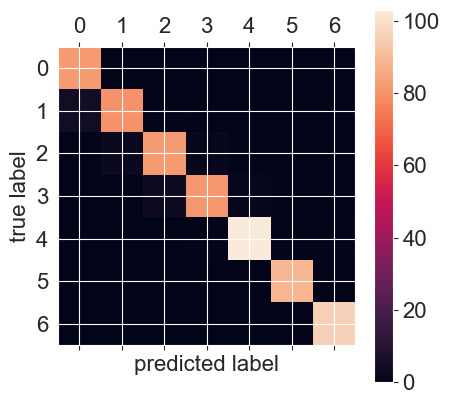

In [61]:
plt_confusion_matrix(pipe_lr_f, X_test, Y_test)

3 --> plt_multi_roc ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']


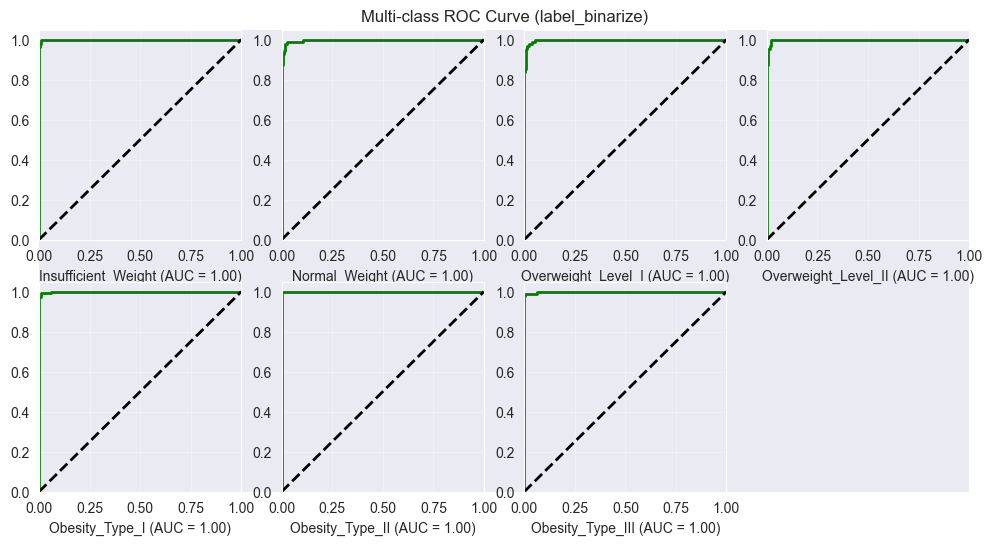

In [15]:
plt_multi_roc(pipe_lr_f, X_test, Y_test)

4 --> plt_multi_pr ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']


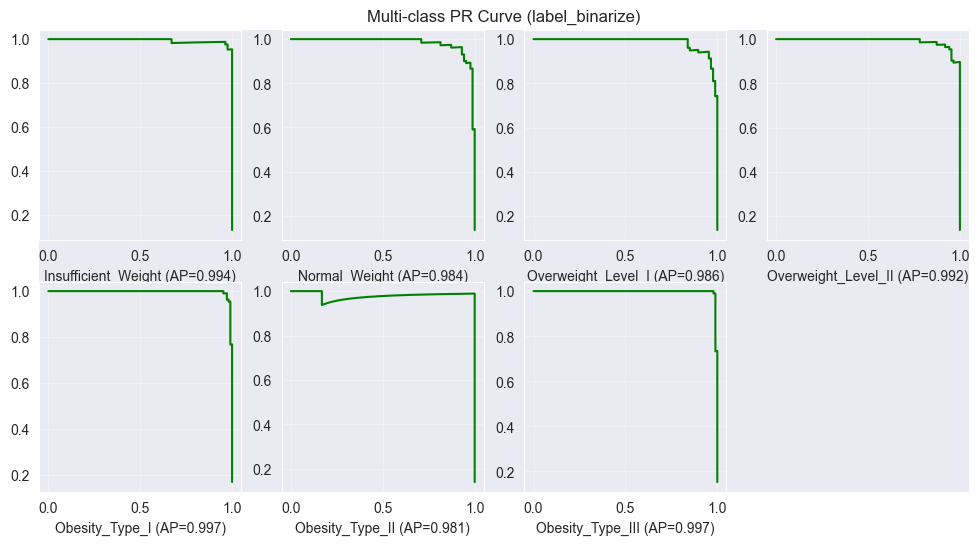

In [16]:
plt_multi_pr(pipe_lr_f, X_test, Y_test)

In [17]:
print("Test Set Bootstrap Confidence Interval:")
my_bootstrap_ci("LogReg", Y_test, pipe_lr_f.predict(X_test))

Test Set Bootstrap Confidence Interval:
6 --> my_bootstrap_ci LogReg
5 --> bootstrap_ci B=1000, alpha=0.05
5 --> bootstrap_ci B=1000, alpha=0.05
[LogReg] Test Accuracy : 0.9669 (95% CI 0.9527-0.9795)
[LogReg] Test Macro-F1 : 0.9660 (95% CI 0.9518-0.9796)


## 1.5 Gradient Boosting Model

### 1.5.1 Choosing gradient boosting model parameters

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder


# create preprocessor
preprocessor_gb = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False,
                              handle_unknown='ignore'), categorical_features)
    ]
)

# create gb pipeline
pipe_gb = Pipeline([
    ('preprocessor', preprocessor_gb),
    ('classifier', GradientBoostingClassifier())
])


In [19]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')


# Perform grid search
param_grid_gb = {
    'classifier__n_estimators': [100, 150, 200],
    'classifier__learning_rate': [0.1],
    'classifier__max_depth': [3, 4, 5],
    'classifier__subsample': [0.8, 1.0],
}

grid_search_gb = GridSearchCV(
    pipe_gb,
    param_grid_gb,
    scoring='f1_macro', # 'accuracy'
    n_jobs=-1,
    verbose=0)

grid_search_gb.fit(X_train, Y_train)

print(f"best_params_: {grid_search_gb.best_params_}")
print(f"best_score_: {grid_search_gb.best_score_:.4f}")


best_params_: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 4, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
best_score_: 0.9670


### 1.5.2 Train the final gradient boosting model

In [20]:
# Create gb pipeline
pipe_gb_f = Pipeline([
    ('preprocessor', preprocessor_gb),
    ('classifier', GradientBoostingClassifier(
                n_estimators=grid_search_gb.best_params_['classifier__n_estimators'],
                learning_rate=grid_search_gb.best_params_['classifier__learning_rate'],
                max_depth=grid_search_gb.best_params_['classifier__max_depth'],
                subsample=grid_search_gb.best_params_['classifier__subsample']))
])

pipe_gb_f.fit(X_train, Y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### 1.5.3 Evaluating the gradient boosting model

In [30]:
print_classification_report(pipe_gb_f, X_test, Y_test)

1 --> print_classification_report ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']
Classification report (0=Insufficient_Weight, 1=Normal_Weight, 2=Overweight_Level_I, 3=Overweight_Level_II, 4=Obesity_Type_I, 5=Obesity_Type_II, 6=Obesity_Type_III):

                     precision    recall  f1-score   support

Insufficient_Weight       0.96      0.98      0.97        82
      Normal_Weight       0.90      0.94      0.92        86
 Overweight_Level_I       0.96      0.89      0.92        87
Overweight_Level_II       0.95      0.97      0.96        87
     Obesity_Type_I       0.97      0.99      0.98       106
    Obesity_Type_II       1.00      0.99      0.99        89
   Obesity_Type_III       1.00      1.00      1.00        97

           accuracy                           0.97       634
          macro avg       0.96      0.96      0.96       634
       weighted avg       0.97      0.97    

2 --> plt_confusion_matrix ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']
Confusion matrix (0=Insufficient_Weight, 1=Normal_Weight, 2=Overweight_Level_I, 3=Overweight_Level_II, 4=Obesity_Type_I, 5=Obesity_Type_II, 6=Obesity_Type_III):



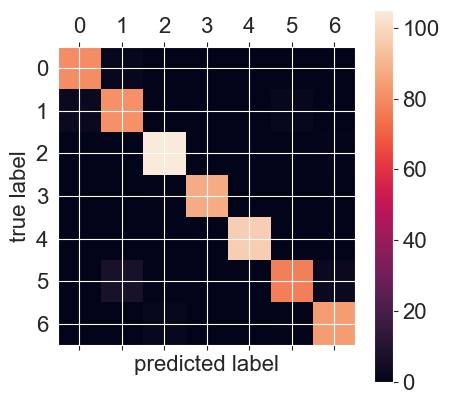

In [48]:
plt_confusion_matrix(pipe_gb_f, X_test, Y_test)

3 --> plt_multi_roc ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']


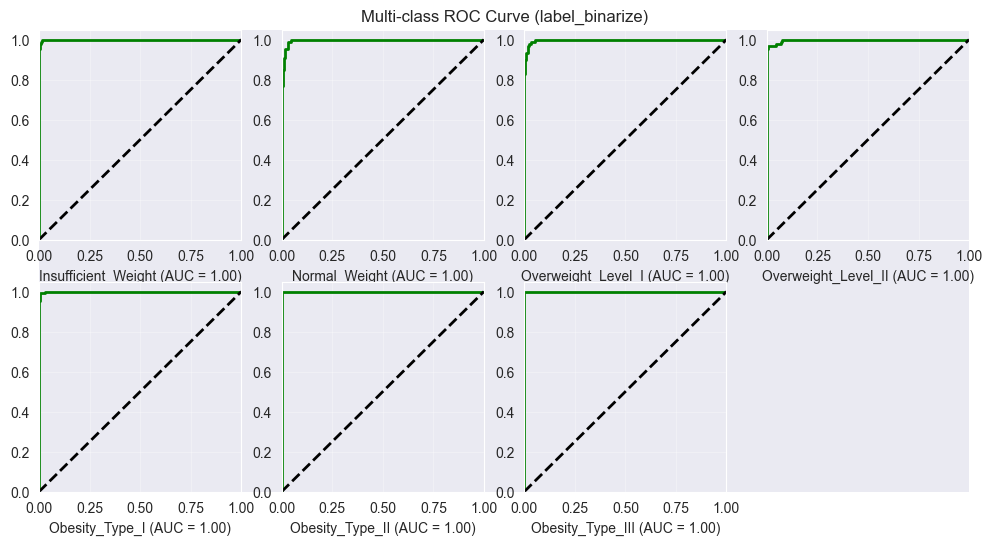

In [23]:
plt_multi_roc(pipe_gb_f, X_test, Y_test)

4 --> plt_multi_pr ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']


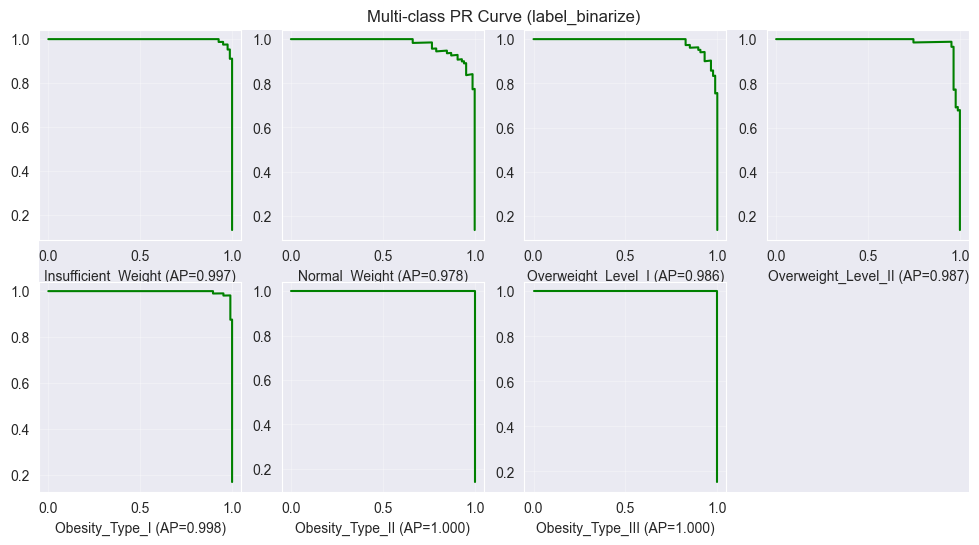

In [24]:
plt_multi_pr(pipe_gb_f, X_test, Y_test)

In [25]:
print("Test Set Bootstrap Confidence Interval:")
my_bootstrap_ci("GB", Y_test, pipe_gb_f.predict(X_test))

Test Set Bootstrap Confidence Interval:
6 --> my_bootstrap_ci GB
5 --> bootstrap_ci B=1000, alpha=0.05
5 --> bootstrap_ci B=1000, alpha=0.05
[GB] Test Accuracy : 0.9655 (95% CI 0.9511-0.9779)
[GB] Test Macro-F1 : 0.9641 (95% CI 0.9492-0.9784)


## 1.6 Comparison of Logistic Regression and Gradient Boosting

In [26]:
import numpy as np
from sklearn.base import clone
from sklearn.model_selection import KFold, StratifiedKFold
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

def five_by_two_cv_test(classifier1, classifier2, X, y, metric='accuracy', random_state=41):
    """
    Perform 5x2 cross-validation paired t-tests

    Parameters:
    classifier1: First Classifier
    classifier2: Second Classifier
    X: Feature Data
    y: Label Data
    metric: Evaluation Indicators ('accuracy', 'f1')
    random_state: Random seed

    Return:
    t_statistic: t_statistic
    p_value: p_value
    results: Detailed Results Dictionary
    """

    # Set the random seed
    np.random.seed(random_state)

    # Storing the differences for each iteration
    differences = []
    variances = []
    all_scores_clf1 = []
    all_scores_clf2 = []

    # 5 repetitions
    for i in range(5):
        # Shuffle data randomly each time
        indices = np.random.permutation(len(X))
        X_permuted = X.loc[indices, :]
        y_permuted = y[indices]

        # 2-fold cross-validation
        kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=random_state+i)
        fold_differences = []

        for train_idx, test_idx in kf.split(X_permuted, y_permuted):
            X_train, X_test = X_permuted.loc[train_idx, :], X_permuted.loc[test_idx, :]
            y_train, y_test = y_permuted[train_idx], y_permuted[test_idx]

            # Clone classifiers to ensure independence
            clf1 = clone(classifier1)
            clf2 = clone(classifier2)

            # Training and Prediction
            clf1.fit(X_train, y_train)
            clf2.fit(X_train, y_train)

            y_pred1 = clf1.predict(X_test)
            y_pred2 = clf2.predict(X_test)

            # Calculate performance metrics
            if metric == 'accuracy':
                score1 = accuracy_score(y_test, y_pred1)
                score2 = accuracy_score(y_test, y_pred2)
            elif metric == 'f1':
                score1 = f1_score(y_test, y_pred1, average='weighted')
                score2 = f1_score(y_test, y_pred2, average='weighted')
            else:
                raise ValueError("For unsupported metrics, please select 'accuracy' or 'f1'")

            all_scores_clf1.append(score1)
            all_scores_clf2.append(score2)
            fold_differences.append(score1 - score2)

        differences.extend(fold_differences)
        # Calculate the variance for each repetition.
        variances.append(np.var(fold_differences, ddof=1))

    differences = np.array(differences)
    variances = np.array(variances)

    # Calculate the paired t-test statistic for 5x2
    # Using the formula proposed by Dietterich (1998)
    mean_diff = np.mean(differences)
    mean_variance = np.mean(variances)

    # Calculation of t-statistics
    t_statistic = mean_diff / np.sqrt(mean_variance / 5)

    # Degree of freedom: 5 (number of repetitions)
    p_value = 2 * (1 - stats.t.cdf(np.abs(t_statistic), df=5))

    # Organized results
    results = {
        't_statistic': t_statistic,
        'p_value': p_value,
        'mean_difference': mean_diff,
        'mean_score_clf1': np.mean(all_scores_clf1),
        'mean_score_clf2': np.mean(all_scores_clf2),
        'std_score_clf1': np.std(all_scores_clf1),
        'std_score_clf2': np.std(all_scores_clf2),
        'all_differences': differences,
        'all_scores_clf1': all_scores_clf1,
        'all_scores_clf2': all_scores_clf2
    }

    return t_statistic, p_value, results

def visualize_results(results, classifier1_name="Classifier 1", classifier2_name="Classifier 2"):
    plt.rcParams.update({'font.size': 16})
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Performance Score Distribution
    axes[0, 0].boxplot([results['all_scores_clf1'], results['all_scores_clf2']],
                      labels=[classifier1_name, classifier2_name])
    axes[0, 0].set_title('Model Performance Distribution (10 Tests)')
    axes[0, 0].set_ylabel('Score')

    # 2. Distribution of Performance Differences

    axes[0, 1].hist(results['all_differences'], bins=10, alpha=0.7, edgecolor='black')
    axes[0, 1].axvline(x=0, color='red', linestyle='--', label='Indifference curve')
    axes[0, 1].axvline(x=results['mean_difference'], color='blue', linestyle='-',
                      label=f'Average difference: {results["mean_difference"]:.4f}')
    axes[0, 1].set_title('Distribution of Performance Differences')
    axes[0, 1].set_xlabel(f'{classifier1_name} - {classifier2_name} the scoring difference')
    axes[0, 1].legend()

    # 3. Performance Scoreline
    iterations = range(1, 11)
    axes[1, 0].plot(iterations, results['all_scores_clf1'], 'o-', label=classifier1_name)
    axes[1, 0].plot(iterations, results['all_scores_clf2'], 's-', label=classifier2_name)
    axes[1, 0].set_xlabel('Test Iteration')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].set_title('Performance score for each test')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Statistical Test Information
    axes[1, 1].axis('off')
    info_text = f"""
    Statistical Test Results:

    {classifier1_name} Average Score: {results['mean_score_clf1']:.4f}
    {classifier2_name} Average Score: {results['mean_score_clf2']:.4f}

    Average difference: {results['mean_difference']:.4f}
    t_statistic: {results['t_statistic']:.4f}
    p_value: {results['p_value']:.4f}

    Conclusion:
    """
    if results['p_value'] < 0.05:
        if results['mean_difference'] > 0:
            conclusion = f"{classifier1_name} significantly better than {classifier2_name} (p < 0.05)"
        else:
            conclusion = f"{classifier2_name} significantly better than {classifier1_name} (p < 0.05)"
    else:
        conclusion = "There is no significant difference\n    between the two classifiers."

    info_text += conclusion
    axes[1, 1].text(0.1, 0.9, info_text, transform=axes[1, 1].transAxes,
                   fontsize=17, verticalalignment='top', fontfamily='monospace')

    plt.tight_layout()
    plt.show()



5x2 CV paired t-test results
LogReg Average accuracy rate: 0.9560 ± 0.0070
GB Average accuracy rate: 0.9606 ± 0.0065
Average difference (LogReg - GB): -0.0045
t_stat: -1.4690
p_val: 0.2018


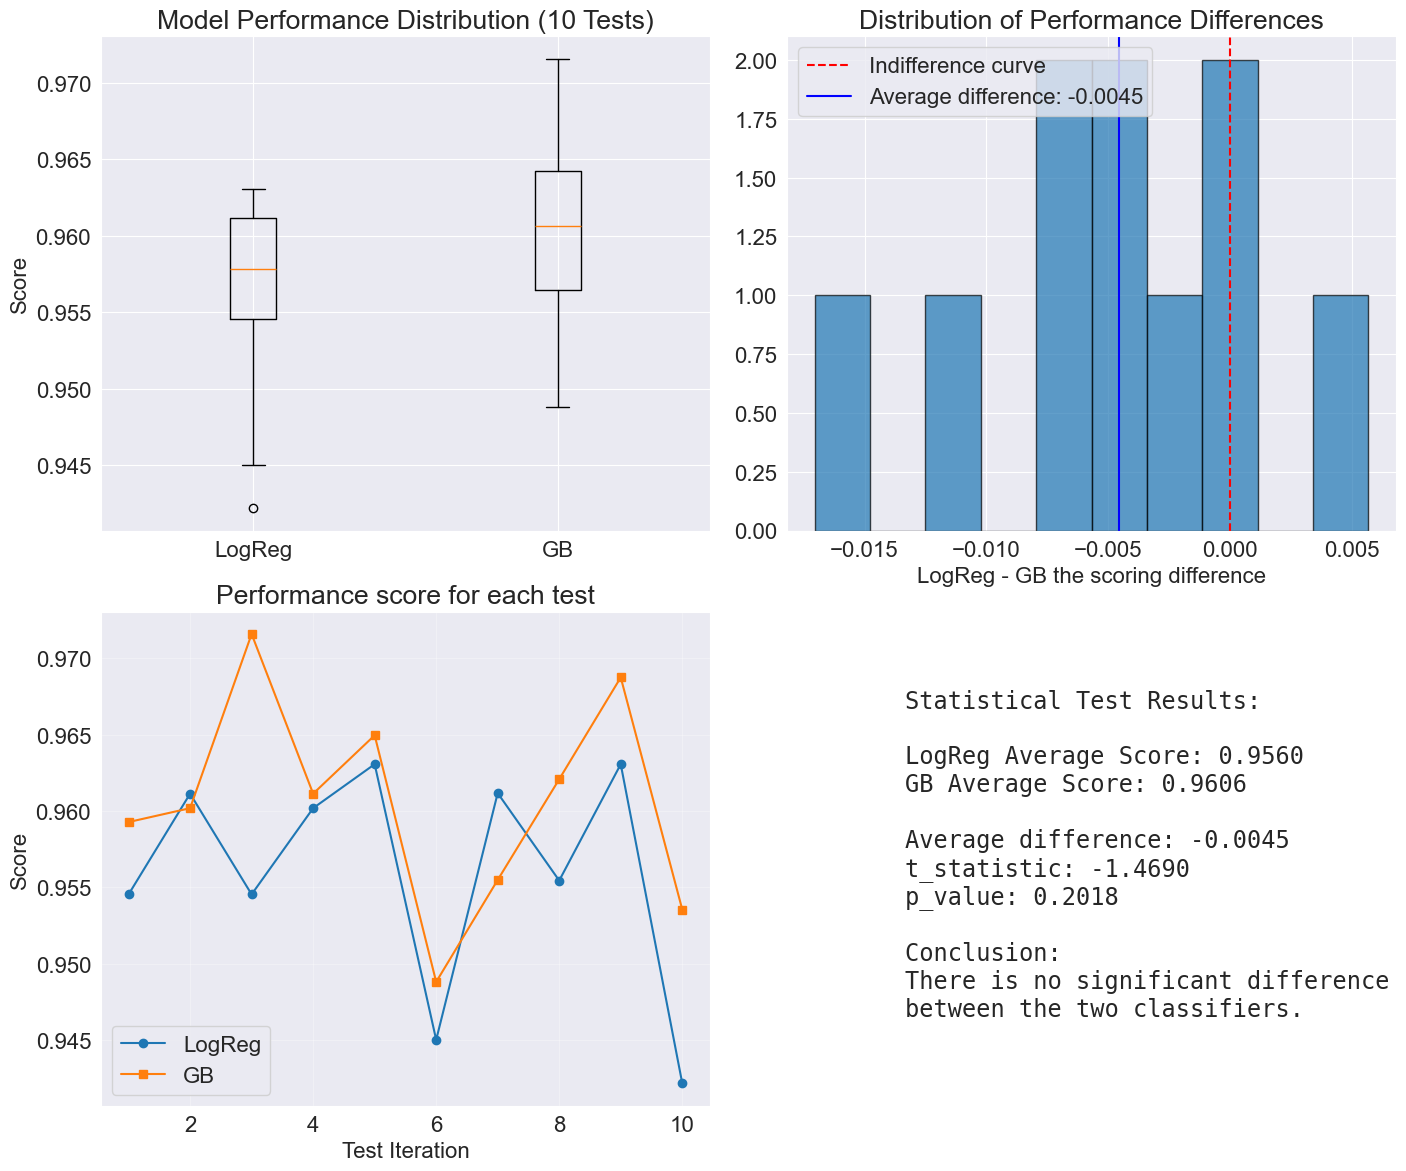

In [27]:
t_stat, p_val, results = five_by_two_cv_test(pipe_lr_f, pipe_gb_f, X, Y)

# print result
print("\n" + "="*50)
print("5x2 CV paired t-test results")
print("="*50)
print(f"LogReg Average accuracy rate: {results['mean_score_clf1']:.4f} ± "
      f"{results['std_score_clf1']:.4f}")
print(f"GB Average accuracy rate: {results['mean_score_clf2']:.4f} ± "
      f"{results['std_score_clf2']:.4f}")
print(f"Average difference (LogReg - GB): {results['mean_difference']:.4f}")
print(f"t_stat: {t_stat:.4f}")
print(f"p_val: {p_val:.4f}")

visualize_results(results, "LogReg", "GB")


## 1.7 Feature Importance Analysis

In [28]:
# Analyzing feature importance through permutation_importance

from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(pipe_lr_f, X_test, Y_test, n_repeats=10, random_state=42)
importance_df = pd.DataFrame({
    'feature': numeric_features + categorical_features,
    'importance': perm_importance.importances_mean,
    'std': perm_importance.importances_std
}).sort_values('importance', ascending=False)
print(importance_df)


                           feature  importance       std
2                           Weight    0.759779  0.010487
1                           Height    0.379968  0.010257
8                           Gender    0.134543  0.008840
3                             FCVC    0.084069  0.008197
14                            CALC    0.062145  0.010372
4                              NCP    0.029022  0.004185
0                              Age    0.024921  0.004221
9   family_history_with_overweight    0.018770  0.003892
15                          MTRANS    0.017981  0.003611
11                            CAEC    0.007729  0.003762
5                             CH2O    0.005521  0.003013
10                            FAVC    0.005047  0.001970
7                              TUE    0.004259  0.004055
6                              FAF    0.003943  0.004363
12                           SMOKE    0.001577  0.000000
13                             SCC    0.000158  0.000473


In [29]:
# Analyzing Feature Importance Through LogReg Coefficients and PCA Weights

pca = pipe_lr_f.named_steps['pca']
pca_components = pca.components_

logreg = pipe_lr_f.named_steps['classifier']
logreg_coef = logreg.coef_

original_feature_importance = np.dot(logreg_coef[0], pca_components)
original_feature_names = preprocessor_lr.get_feature_names_out()

feature_importance_df = pd.DataFrame({
    'feature': original_feature_names,
    'importance': original_feature_importance
}).sort_values('importance', key=abs, ascending=False)

print(feature_importance_df)


                                    feature  importance
2                               num__Weight  -94.924212
1                               num__Height   25.125403
8                          cat__Gender_Male    3.820838
21        cat__MTRANS_Public_Transportation   -3.707028
13                             cat__CAEC_no   -2.750195
11                     cat__CAEC_Frequently    2.304034
0                                  num__Age   -1.100308
17                      cat__CALC_Sometimes   -1.008767
16                     cat__CALC_Frequently    0.921717
5                                 num__CH2O    0.705423
20                    cat__MTRANS_Motorbike   -0.616200
12                      cat__CAEC_Sometimes    0.596771
9   cat__family_history_with_overweight_yes   -0.439584
10                            cat__FAVC_yes    0.356909
4                                  num__NCP   -0.283457
6                                  num__FAF    0.247074
18                             cat__CALC_no    0